In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.cluster import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from collections import Counter

In [122]:
# Read the data
geo = pd.read_csv("/kaggle/input/outliers/geo_size.csv", index_col = "index")
socioeconomic = pd.read_csv("/kaggle/input/outliers1/socioeconomic.csv", index_col = "index")

## As a first step we merge both files using "index" column

In [147]:
# Merging both files by left-join
data = geo.merge(socioeconomic, left_on= "index", right_on="index", how="left")
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   statefips                3220 non-null   int64  
 1   countyfips               3220 non-null   int64  
 2   avghouseholdsize         3220 non-null   float64
 3   geography_x              3220 non-null   object 
 4   avganncount              3047 non-null   float64
 5   avgdeathsperyear         3047 non-null   float64
 6   target_deathrate         3047 non-null   float64
 7   incidencerate            3047 non-null   float64
 8   medincome                3047 non-null   float64
 9   popest2015               3047 non-null   float64
 10  povertypercent           3047 non-null   float64
 11  studypercap              3047 non-null   float64
 12  binnedinc                3047 non-null   object 
 13  medianage                3047 non-null   float64
 14  medianagemale            3047

## Outlier detection using IQR rule

Outlier analysis is the process of identifying outliers, or abnormal observations, in a dataset. Also known as outlier detection, it’s an important step in data analysis, as it removes erroneous or inaccurate observations which might otherwise skew conclusions and bias the results. In our case we will use IQR rule to detect the outliers.

IQR is the range between the first and the third quartiles namely Q1 and Q3: IQR = Q3 – Q1. The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

In [124]:
# Create a function that deals with outliers
def outliers_detection(dataframe):
    """ A function that return tuple with dictionary that contains number of outliers for every column and
        a data frame with the value True/False if the observation is an outlier"""
    dframe = dataframe.copy()
    dict_of_outliers = dict()
    df_dict = dict()
    for col in dataframe.columns:
        if dframe[col].dtype != "object":
            dframe[col].fillna(dframe[col].mean(), inplace = True)
            inter_quartile = iqr(dframe[col])
            lower_boundary = np.quantile(dframe[col], 0.25) - (1.5 * inter_quartile)
            upper_boundary = np.quantile(dframe[col], 0.75) + (1.5 * inter_quartile)
            num_outliers = dframe[col].where((dframe[col] < lower_boundary) | (dframe[col] > upper_boundary)).count()
            dict_of_outliers[col] = num_outliers
            df_dict[col] = ~dframe[col].where((dframe[col] < lower_boundary) | (dframe[col] > upper_boundary)).isna()
    return dict_of_outliers, pd.DataFrame(df_dict)

The plot reveals that the variable "pctsomecol18_24" has the highest number of observations, reaching nearly 800, classified as outliers. Following closely are the columns "pctblack" and "avganncount," each containing slightly over 400 observations identified as outliers.

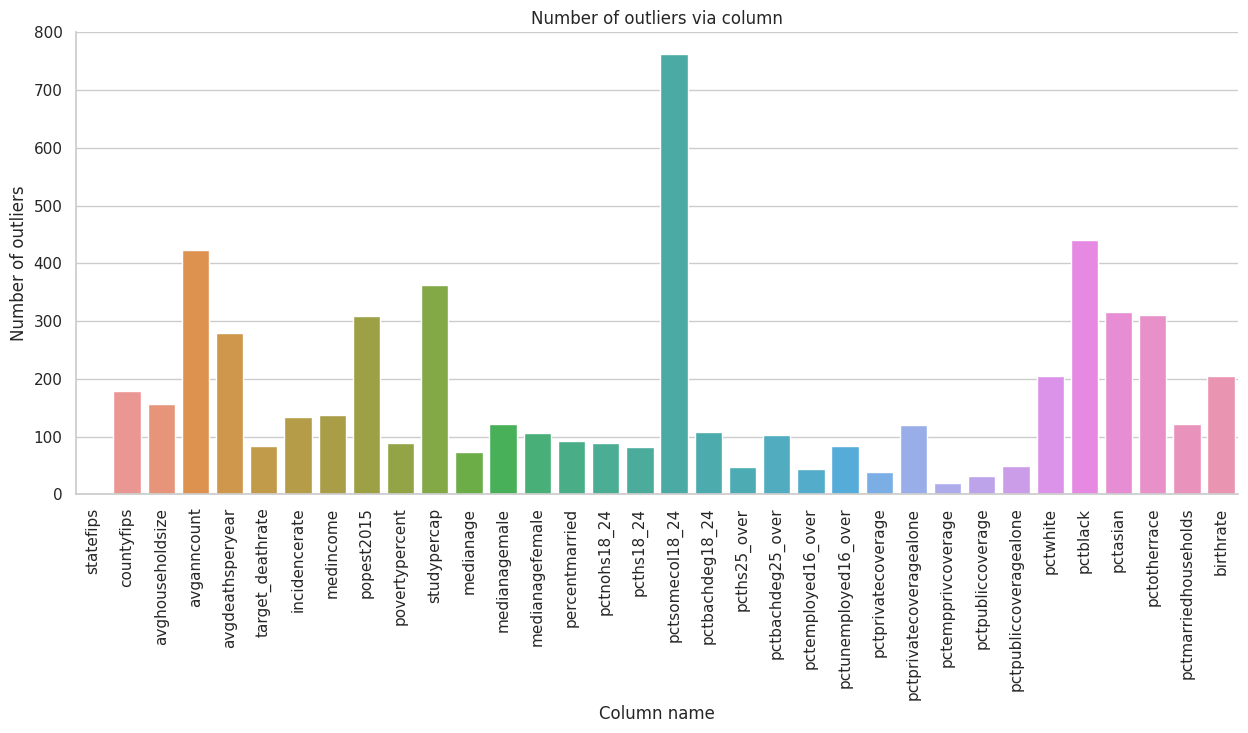

In [125]:
# Execute the function
outliers = pd.Series(outliers_detection(data)[0]).reset_index().rename({"index":"column_name", 0:"number_of_outliers"}, 
                                                                       axis = 1)
fig, ax = plt.subplots(figsize = (15,6))
sns.set(style = "whitegrid", palette = "pastel", color_codes = True)
sns.despine(top = True, right = True)
sns.barplot(data = outliers, x = outliers.column_name, y = outliers.number_of_outliers)
ax.set_title("Number of outliers via column")
ax.set_xlabel("Column name")
ax.set_ylabel("Number of outliers")
ax.set_xticklabels(outliers.column_name, rotation = 90)
plt.show()

Prior to employing alternative techniques, we plan to eliminate the columns "pctsomecol18_24", "pctblack" and "avganncount" The decision is rooted in the observation that these columns harbor the highest number of outliers, and their presence contributes significantly to bias within the dataset. By excluding these specific columns, we aim to mitigate the impact of outliers, paving the way for a more balanced and unbiased analysis.

In [148]:
del data["pctsomecol18_24"]
del data["pctblack"]
del data["avganncount"]

## Unsupervised learning techniques for outliers detection

Now, we perform imputation to deal with NA's before performing unsupervised learning methods. We will input mean value in the NA'a cells

In [150]:
# Find numeric columns in the dataset
numeric_columns = list()
for column in data.columns:
    if data[column].dtype != "object":
        numeric_columns.append(column)
# Define the data set with conaining numeric columns from initial data set
data_numeric = data[numeric_columns]
print(f"Number of missing values before: {data_numeric.isna().sum().sum()}")
#-------------------------------------
# We will input the NA with mean value
#-------------------------------------
# Define the function
def na_mean_inputation(dataframe):
    """Input NA values in every column with the mean"""
    for col in dataframe.columns:
        dataframe.loc[:,col]=dataframe[col].fillna(dataframe[col].mean())
    return dataframe
# Execute the function
data_numeric_without_NA=na_mean_inputation(data_numeric)
print(f"Number of missing values after: {data_numeric.isna().sum().sum()}")

Number of missing values before: 5605
Number of missing values after: 0


The next step before clustering will be data standardization

In [151]:
# Standardization of the data
scaler = StandardScaler()
scaler.fit(data_numeric_without_NA)
data_numeric_standardized = scaler.transform(data_numeric_without_NA)

## t-SNE
We may also use t-SNE dimension reduction method to "glimpse" at the data to see whether some points might be seen as obvious outliers.
Specifically, it models each high-dimensional object by a two dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. If we choose a point and there are some points in the proximity of the point, the points are similar to each other in the input space (high dimensional space).

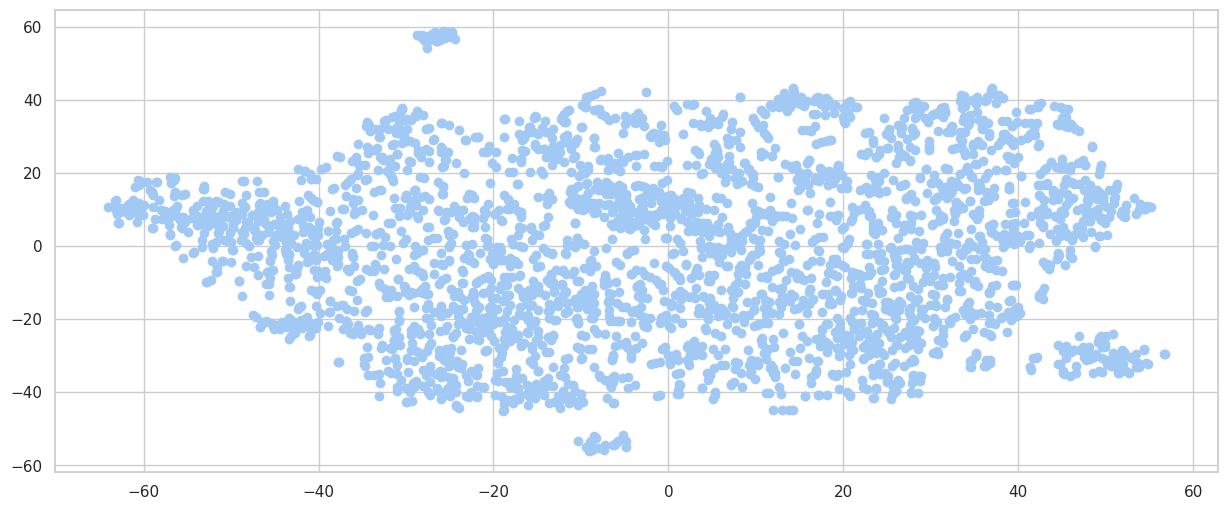

In [152]:
# We perform TSNE algorithm
visual_model = TSNE(learning_rate=100)
transformed = visual_model.fit_transform(data_numeric_standardized)
xs = transformed[:, 0]
ys = transformed[:, 1]
plt.figure(figsize= (15,6))
plt.scatter(xs, ys)
plt.show()

## DBSCAN
DBSCAN is Density-based spatial clustering of applications with Noise. This unsupervised learning algorithm is perfect method to detect outliers in your data if your data points are densely grouped and you need to extract some data noise from there (outliers).

In [162]:
model = dbscan(data_numeric_standardized, eps = 0.5, min_samples = 15)
Counter(model[1])

Counter({-1: 3053, 0: 167})

## Visualization of DBSCAN performance using t-SNE

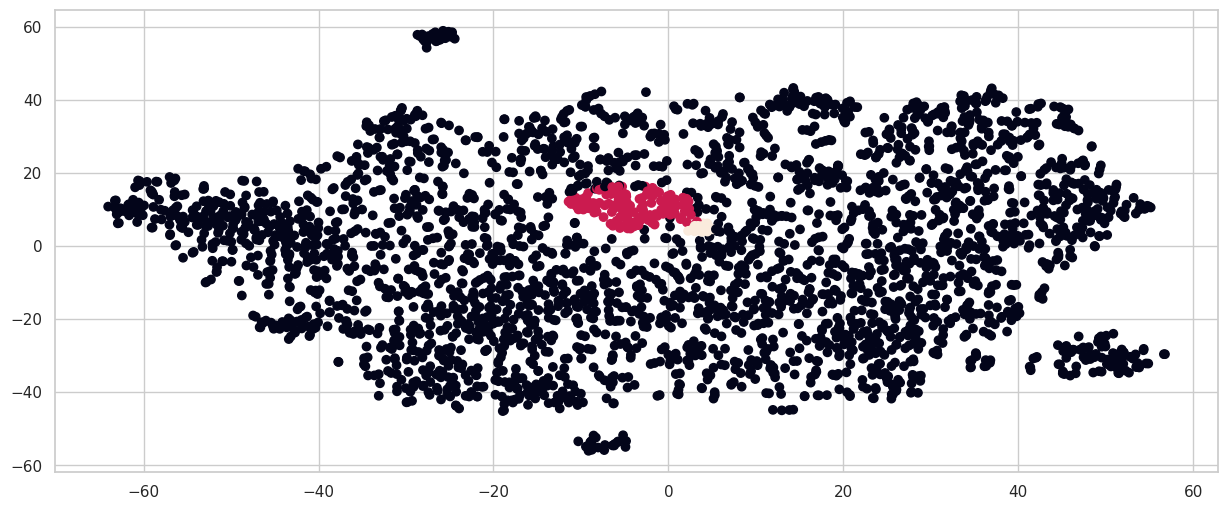

In [158]:
fig, ax = plt.subplots(figsize = (15,6))
ax.scatter(xs, ys, c = model[1])

## Summary

The majority of points in our dataset exhibit substantial distances from each other, with 3053 out of 3220 points showing notable separation. Consequently, after examining the t-SNE plot and applying the DBSCAN algorithm, we have opted to exclude these 3053 observations. The rationale behind this decision is to eliminate instances that contribute to the lack of homogeneity within the dataset, a factor that could introduce potential bias in subsequent analyses. As a result, we will retain only 167 observations, focusing on a subset that demonstrates more cohesive and uniform grouping for further analysis.

## Final glimpse at the dataset...

In [163]:
data["label"] = model[1]
final_data = data.query('label == 0')
final_data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 3047 to 3219
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   statefips                167 non-null    int64  
 1   countyfips               167 non-null    int64  
 2   avghouseholdsize         167 non-null    float64
 3   geography_x              167 non-null    object 
 4   avgdeathsperyear         0 non-null      float64
 5   target_deathrate         0 non-null      float64
 6   incidencerate            0 non-null      float64
 7   medincome                0 non-null      float64
 8   popest2015               0 non-null      float64
 9   povertypercent           0 non-null      float64
 10  studypercap              0 non-null      float64
 11  binnedinc                0 non-null      object 
 12  medianage                0 non-null      float64
 13  medianagemale            0 non-null      float64
 14  medianagefemale          0 